In [1]:
def to_device(x, device="cuda:0"):
    if isinstance(x, dict):
        return {k: to_device(v) for k, v in x.items()}
    return x.to(device=device)

## Load Model

In [2]:
!pip install -qU transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel
from transformers import AutoModel, AutoTokenizer

In [4]:
text_tokenizer = AutoTokenizer.from_pretrained('arman-aminian/clip-farsi-text')
text_encoder = AutoModel.from_pretrained('arman-aminian/clip-farsi-text').to(device='cuda:0')
image_encoder = CLIPVisionModel.from_pretrained('arman-aminian/clip-farsi-vision').to(device='cuda:0')

## Load Data

In [5]:
!pip install -qU transformers kaggle

In [7]:
import os

os.environ['KAGGLE_USERNAME'] = "sinapakseresht"
os.environ['KAGGLE_KEY'] = "547e053309bbbd949963af6c3afd368e"

!kaggle datasets download -d hsankesara/flickr-image-dataset

!unzip -q /content/flickr-image-dataset.zip

100% 8.16G/8.16G [01:41<00:00, 167MB/s]
100% 8.16G/8.16G [01:41<00:00, 86.7MB/s]


## Load translation

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('/content/drive/MyDrive/University/MLOps/MLOps-Project/Phase-3/flickr30k_translated.csv')
df.head()

,image_name,comment_number,comment,translation,translation_score
0,1000092795.jpg,3,A man in a blue shirt standing in a garden .,مردی با پیراهن آبی که در یک باغ ایستاده است.,0.901372
1,1000092795.jpg,4,Two friends enjoy time spent together .,دو دوست از زمان با هم بودن لذت می برند.,0.904042
2,10002456.jpg,0,Several men in hard hats are operating a giant...,چند مرد با کلاه سخت در حال کار با یک سیستم قرق...,0.901948
3,10002456.jpg,1,Workers look down from up above on a piece of ...,کارگران از بالا به یک قطعه تجهیزات نگاه می کنند.,0.875552
4,10002456.jpg,2,Two men working on a machine wearing hard hats .,دو مرد با کلاه سخت روی ماشینی کار می کنند.,0.842425


In [15]:
sampled_df = df.sample(n=1000)

## Text Embeddings

In [11]:
! pip install -qU tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 1.6 MB/s eta 0:00:00


In [12]:
from tqdm import tqdm
import torch

In [13]:
def calc_embedding_for_text(text):
    with torch.no_grad():
        tokenized = text_tokenizer(text, return_tensors='pt')
        embedding = text_encoder(**to_device(tokenized)).pooler_output
    return embedding.squeeze().cpu().tolist()

In [24]:
text_embeddings = []
for i, row in tqdm(sampled_df.iterrows()):
    text_embeddings.append(calc_embedding_for_text(row['translation']))

1000it [00:31, 32.09it/s]


## Image Embeddings

In [20]:
import torchvision.transforms as transforms
from PIL import Image

In [21]:
def calc_embedding_for_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
        )
    ])
    image = preprocess(Image.open(image_path).convert('RGB'))
    image = image.unsqueeze(0)
    with torch.no_grad():
        embedding = image_encoder(to_device(image)).pooler_output
    return embedding.squeeze().cpu().tolist()

In [25]:
image_embeddings = []
for i, row in tqdm(sampled_df.iterrows()):
    image_embeddings.append(calc_embedding_for_image(f'/content/flickr30k_images/flickr30k_images/{row["image_name"]}'))

1000it [00:33, 29.42it/s]


## Pairwise Cosine Similarity

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_matrix = cosine_similarity(text_embeddings, image_embeddings)

In [31]:
cosine_matrix.shape

(1000, 1000)

## Metrics

### Top k Accuracy

In [39]:
def is_index_in_top_k(k, i, array):
    arg_sorted = array.argsort()
    return True if i in arg_sorted[-k:] else False

def accuracy_at_k(k, cosine_matrix):
    is_in_top_k_count = 0
    for i in range(cosine_matrix.shape[0]):
        if is_index_in_top_k(k, i, cosine_matrix[i, :]):
            is_in_top_k_count += 1
    return is_in_top_k_count / cosine_matrix.shape[0]

In [53]:
accuracy_at = {}
for k in range(1, 51):
    accuracy_at[k] = accuracy_at_k(k, cosine_matrix)
    print(f"accuracy @ {k:<3}: {accuracy_at[k]}")

accuracy @ 1  : 0.204
accuracy @ 2  : 0.312
accuracy @ 3  : 0.379
accuracy @ 4  : 0.442
accuracy @ 5  : 0.488
accuracy @ 6  : 0.527
accuracy @ 7  : 0.561
accuracy @ 8  : 0.598
accuracy @ 9  : 0.619
accuracy @ 10 : 0.636
accuracy @ 11 : 0.654
accuracy @ 12 : 0.665
accuracy @ 13 : 0.681
accuracy @ 14 : 0.692
accuracy @ 15 : 0.704
accuracy @ 16 : 0.716
accuracy @ 17 : 0.728
accuracy @ 18 : 0.742
accuracy @ 19 : 0.755
accuracy @ 20 : 0.762
accuracy @ 21 : 0.766
accuracy @ 22 : 0.776
accuracy @ 23 : 0.784
accuracy @ 24 : 0.793
accuracy @ 25 : 0.799
accuracy @ 26 : 0.801
accuracy @ 27 : 0.806
accuracy @ 28 : 0.811
accuracy @ 29 : 0.817
accuracy @ 30 : 0.822
accuracy @ 31 : 0.828
accuracy @ 32 : 0.835
accuracy @ 33 : 0.837
accuracy @ 34 : 0.842
accuracy @ 35 : 0.845
accuracy @ 36 : 0.847
accuracy @ 37 : 0.849
accuracy @ 38 : 0.85
accuracy @ 39 : 0.853
accuracy @ 40 : 0.859
accuracy @ 41 : 0.862
accuracy @ 42 : 0.867
accuracy @ 43 : 0.871
accuracy @ 44 : 0.871
accuracy @ 45 : 0.872
accuracy @ 

### Plot

In [42]:
!pip install -qU seaborn

In [43]:
import seaborn as sns

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<Axes: >

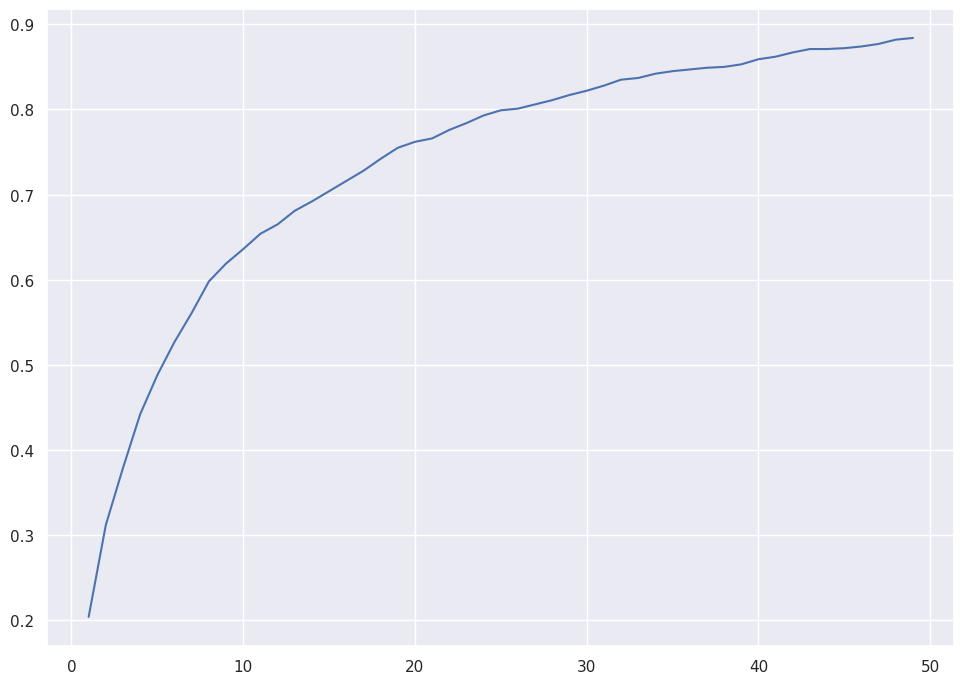

In [47]:
sns.lineplot(x=accuracy_at.keys(), y=accuracy_at.values())

# Accuracy @ K For Multiple Models

In [58]:
def calc_accuracy_at(text_model_name, image_model_name):

    # load models
    text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)
    text_encoder = AutoModel.from_pretrained(text_model_name).to(device='cuda:0')
    image_encoder = CLIPVisionModel.from_pretrained(image_model_name).to(device='cuda:0')

    # read and sample data
    df = pd.read_csv('/content/drive/MyDrive/University/MLOps/MLOps-Project/Phase-3/flickr30k_translated.csv')
    sampled_df = df.sample(n=10000)

    # text
    text_embeddings = []
    for i, row in tqdm(sampled_df.iterrows()):
        text_embeddings.append(calc_embedding_for_text(row['translation']))

    # image
    image_embeddings = []
    for i, row in tqdm(sampled_df.iterrows()):
        image_embeddings.append(calc_embedding_for_image(f'/content/flickr30k_images/flickr30k_images/{row["image_name"]}'))

    # cosine similarity
    cosine_matrix = cosine_similarity(text_embeddings, image_embeddings)

    # accuracy
    accuracy_at = {}
    for k in range(1, 51):
        accuracy_at[k] = accuracy_at_k(k, cosine_matrix)
    return accuracy_at

In [57]:
# sample_size: 1000
for model_name in ["5nUwt", "MGXRW", "OhbVr"]:
    print(f"model_name: {model_name}")
    accuracy_at = calc_accuracy_at(f"arman-aminian/clip-farsi-text-{model_name}", f"arman-aminian/clip-farsi-vision-{model_name}")
    print(f"accuracy_at: {accuracy_at}")
    print()

model_name: 5nUwt


1000it [00:15, 66.21it/s]
1000it [00:20, 48.38it/s]


accuracy_at: {1: 0.234, 2: 0.35, 3: 0.41, 4: 0.478, 5: 0.529, 6: 0.556, 7: 0.581, 8: 0.607, 9: 0.637, 10: 0.66, 11: 0.674, 12: 0.7, 13: 0.715, 14: 0.722, 15: 0.734, 16: 0.747, 17: 0.749, 18: 0.762, 19: 0.769, 20: 0.78, 21: 0.792, 22: 0.796, 23: 0.804, 24: 0.816, 25: 0.824, 26: 0.83, 27: 0.836, 28: 0.84, 29: 0.844, 30: 0.846, 31: 0.852, 32: 0.855, 33: 0.862, 34: 0.866, 35: 0.871, 36: 0.875, 37: 0.879, 38: 0.879, 39: 0.882, 40: 0.886, 41: 0.887, 42: 0.888, 43: 0.889, 44: 0.891, 45: 0.894, 46: 0.894, 47: 0.898, 48: 0.898, 49: 0.901, 50: 0.905}

model_name: MGXRW


1000it [00:12, 81.03it/s]
1000it [00:20, 49.93it/s]


accuracy_at: {1: 0.204, 2: 0.31, 3: 0.386, 4: 0.436, 5: 0.474, 6: 0.507, 7: 0.535, 8: 0.565, 9: 0.591, 10: 0.628, 11: 0.647, 12: 0.665, 13: 0.684, 14: 0.692, 15: 0.702, 16: 0.716, 17: 0.727, 18: 0.744, 19: 0.756, 20: 0.768, 21: 0.778, 22: 0.784, 23: 0.797, 24: 0.807, 25: 0.809, 26: 0.816, 27: 0.821, 28: 0.829, 29: 0.831, 30: 0.834, 31: 0.837, 32: 0.841, 33: 0.847, 34: 0.852, 35: 0.855, 36: 0.856, 37: 0.859, 38: 0.862, 39: 0.864, 40: 0.866, 41: 0.867, 42: 0.868, 43: 0.872, 44: 0.874, 45: 0.875, 46: 0.877, 47: 0.877, 48: 0.878, 49: 0.88, 50: 0.881}

model_name: OhbVr


1000it [00:13, 75.06it/s]
1000it [00:19, 50.35it/s]


accuracy_at: {1: 0.197, 2: 0.303, 3: 0.378, 4: 0.437, 5: 0.486, 6: 0.524, 7: 0.55, 8: 0.576, 9: 0.606, 10: 0.64, 11: 0.664, 12: 0.678, 13: 0.694, 14: 0.708, 15: 0.716, 16: 0.723, 17: 0.73, 18: 0.737, 19: 0.749, 20: 0.756, 21: 0.763, 22: 0.772, 23: 0.784, 24: 0.792, 25: 0.798, 26: 0.804, 27: 0.811, 28: 0.815, 29: 0.818, 30: 0.825, 31: 0.828, 32: 0.835, 33: 0.84, 34: 0.845, 35: 0.847, 36: 0.85, 37: 0.853, 38: 0.857, 39: 0.859, 40: 0.863, 41: 0.863, 42: 0.865, 43: 0.869, 44: 0.871, 45: 0.873, 46: 0.875, 47: 0.877, 48: 0.877, 49: 0.879, 50: 0.882}



# Send Metrics to MLFlow

In [1]:
import mlflow

mlflow.set_tracking_uri("https://mlflow-mlsd-video-search.darkube.app")

In [4]:
# copied from results of evaluation & run in local (not colab)
accuracy_at_data_for_models = {
    "5nUwt": {1: 0.234, 2: 0.35, 3: 0.41, 4: 0.478, 5: 0.529, 6: 0.556, 7: 0.581, 8: 0.607, 9: 0.637, 10: 0.66, 11: 0.674, 12: 0.7, 13: 0.715, 14: 0.722, 15: 0.734, 16: 0.747, 17: 0.749, 18: 0.762, 19: 0.769, 20: 0.78, 21: 0.792, 22: 0.796, 23: 0.804, 24: 0.816, 25: 0.824, 26: 0.83, 27: 0.836, 28: 0.84, 29: 0.844, 30: 0.846, 31: 0.852, 32: 0.855, 33: 0.862, 34: 0.866, 35: 0.871, 36: 0.875, 37: 0.879, 38: 0.879, 39: 0.882, 40: 0.886, 41: 0.887, 42: 0.888, 43: 0.889, 44: 0.891, 45: 0.894, 46: 0.894, 47: 0.898, 48: 0.898, 49: 0.901, 50: 0.905},
    "MGXRW": {1: 0.204, 2: 0.31, 3: 0.386, 4: 0.436, 5: 0.474, 6: 0.507, 7: 0.535, 8: 0.565, 9: 0.591, 10: 0.628, 11: 0.647, 12: 0.665, 13: 0.684, 14: 0.692, 15: 0.702, 16: 0.716, 17: 0.727, 18: 0.744, 19: 0.756, 20: 0.768, 21: 0.778, 22: 0.784, 23: 0.797, 24: 0.807, 25: 0.809, 26: 0.816, 27: 0.821, 28: 0.829, 29: 0.831, 30: 0.834, 31: 0.837, 32: 0.841, 33: 0.847, 34: 0.852, 35: 0.855, 36: 0.856, 37: 0.859, 38: 0.862, 39: 0.864, 40: 0.866, 41: 0.867, 42: 0.868, 43: 0.872, 44: 0.874, 45: 0.875, 46: 0.877, 47: 0.877, 48: 0.878, 49: 0.88, 50: 0.881},
    "OhbVr": {1: 0.197, 2: 0.303, 3: 0.378, 4: 0.437, 5: 0.486, 6: 0.524, 7: 0.55, 8: 0.576, 9: 0.606, 10: 0.64, 11: 0.664, 12: 0.678, 13: 0.694, 14: 0.708, 15: 0.716, 16: 0.723, 17: 0.73, 18: 0.737, 19: 0.749, 20: 0.756, 21: 0.763, 22: 0.772, 23: 0.784, 24: 0.792, 25: 0.798, 26: 0.804, 27: 0.811, 28: 0.815, 29: 0.818, 30: 0.825, 31: 0.828, 32: 0.835, 33: 0.84, 34: 0.845, 35: 0.847, 36: 0.85, 37: 0.853, 38: 0.857, 39: 0.859, 40: 0.863, 41: 0.863, 42: 0.865, 43: 0.869, 44: 0.871, 45: 0.873, 46: 0.875, 47: 0.877, 48: 0.877, 49: 0.879, 50: 0.882},
}

In [8]:
for model_name, accuracy_at in accuracy_at_data_for_models.items():
    with mlflow.start_run(run_name=f"model_name: {model_name} evaluation"):
        for k in range(1, 51):
            mlflow.log_metric(f"accuracy_at", accuracy_at[k], step=k)
            mlflow.log_param("model", model_name)
    mlflow.end_run()